In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split # train, test 데이터 분할
from sklearn.linear_model import LogisticRegression # 로지스틱 모델 적함
from sklearn.tree import DecisionTreeClassifier # 의사결정나무 모델 적합
from sklearn.ensemble import RandomForestClassifier # 랜던포레스트 모델 적합
import sklearn.svm as svm
from sklearn.neural_network import MLPClassifier

from sklearn import tree
import graphviz 

from sklearn.metrics import confusion_matrix # 
from sklearn.metrics import roc_curve, auc


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. 모델 구축 및 평가

## 2.0 평가지표

### 2.0.1 평가지표

In [ ]:
# y예측값 구하기 - 1: y >= threshold, 0: y < threshold
def cut_off(y, threshold):
    Y = y.copy() 
    Y[Y >= threshold]=1
    Y[Y < threshold]=0
    return(Y.astype(int))

# 정확도
def accuracy(cfmat) :
    acc=(cfmat[0,0]+cfmat[1,1]) / np.sum(cfmat) ## accuracy
    return(acc)

# 재현률
def recall(cfmat) :
      rec=(cfmat[1,1]) / (cfmat[1,0] + cfmat[1,1]) ## recall
      return(rec)

# 정밀도
def precision(cfmat) :
      preci=(cfmat[1,1]) / (cfmat[0,1] + cfmat[1,1])  ## precision
      return(preci)

# 가격기댓값
def expect_price(data, cfmat) :
      prior_price = 10000 # 임의의 투자금 10000원 
      interest_rate = data['int_rate'].mean() #groupby로 purpose 별로 int_rate가 서로 차이 많이 남.
      # 미국 기준 금리: 0.5%
      exp_price=(cfmat[0,0]/np.sum(cfmat))*( prior_price *interest_rate ) + (cfmat[1,0]/np.sum(cfmat))*(-prior_price) + (cfmat[0,1]/np.sum(cfmat))*(-prior_price*0.005)

      return(exp_price)

### 2.0.2 로지스틱 threshold 구하기 

In [ ]:
# Validation에 적합하여 threshold 구하기
def Logit_find_threshold(y_valid, y_valid_p, x_valid, threshold1):
    table = pd.DataFrame()

    for i in threshold1:
        pred_Y = cut_off(y_valid_p, i)
        cfmat = confusion_matrix(y_valid, pred_Y)
        table.loc[i, 'accuracy'] = accuracy(cfmat)
        table.loc[i,  'recall'] = recall(cfmat)
        table.loc[i, 'precision'] = precision(cfmat)
        table.loc[i, 'expect_price'] = expect_price(x_valid, cfmat)
    
    table.index.name='threshold'
    table.columns.name='performance'
    best = table['expect_price'].idxmax()
    best_per = pd.DataFrame(table.loc[best]) 

    
    return best, best_per, table

def Logit_best_threshold(valid, y_test, y_test_p, x_test):
    
    best_threshold = valid ['expect_price'].idxmax()
    pred_Y = cut_off(y_test_p, best_threshold )
    cfmat1 = confusion_matrix(y_test, pred_Y)

    table1 = pd.DataFrame()
    table1.loc[1,'accuracy'] = accuracy(cfmat1)
    table1.loc[1,'recall'] = recall(cfmat1)
    table1.loc[1,'precision'] = precision(cfmat1)
    table1.loc[1,'expect_price'] = expect_price(x_test, cfmat1)

    table1.columns.name='performance'
    table1.index = [best_threshold]
    table1.index.name='threshold'
  
    return best_threshold, cfmat1, table1

### 2.0.3 의사결정나무 depth 구하기

In [ ]:
# 의사결정나무의 파라메터: max_depth 깊이, max_features 각 노드에서 분할에 사용할 특성의 최대 수 
# Validation에 적합하여 max_depth와 max_features 구하기
#  max_depth와 max_features 구하기
def DT_find_depth_feature(x_train, y_train, x_valid, y_valid, depth,  feature):

  accur=[]; rec=[]; preci=[]; ep=[]; dep=[]; nf=[];
  for i in depth:
    for j in  feature:
      model = DecisionTreeClassifier(criterion="entropy", max_depth = i, max_features=j)
      result = model.fit(x_train, y_train)
      pred_Y = result.predict(x_valid)
      cfmat1 = confusion_matrix(y_valid, pred_Y)
      accur.append(accuracy(cfmat1))
      rec.append(recall(cfmat1))
      preci.append(precision(cfmat1))
      ep.append(expect_price(x_valid,cfmat1))
      dep.append(i)
      nf.append(j)
      
  table4 = pd.DataFrame()
  table4['depth'] = dep
  table4['max_feature'] = nf
  table4['accuracy'] = accur
  table4['recall'] = rec
  table4['precision'] = preci
  table4['expect_price'] = ep
  table4.columns.name='performance'
  best_ind = table4['expect_price'].idxmax()
  best_per = pd.DataFrame(table4.loc[best_ind]) 
  best = best_per.iloc[:2, :]
  return  best, best_per, table4


# 결정된 max_depth와 max_features로 test data적합
def DT_best_depth(best, x_train, y_train, x_test, y_test):
    
    best_dep = round(best.iloc[0, 0])
    best_feat = round(best.iloc[1, 0])

    model1 = DecisionTreeClassifier(criterion="entropy", max_depth = best_dep, max_features = best_feat)
    best_model = model1.fit(x_train, y_train)
    pred_Y = best_model.predict(x_test)
    cfmat2 = confusion_matrix(y_test, pred_Y)


    table4 = pd.DataFrame()
    table4.loc[1,'accuracy'] = accuracy(cfmat2)
    table4.loc[1,'recall'] = recall(cfmat2)
    table4.loc[1,'precision'] = precision(cfmat2)
    table4.loc[1,'expect_price'] = expect_price(x_test, cfmat2)
    table4.columns.name='performance'
  
    return best_dep, best_feat, best_model, cfmat2, table4

### 2.0.4 랜덤포레스트 파라메타 구하기
- n_estimators: 트리의 갯수 지정
- max_features: 최적의 분할을 위해 고려할 최대 feature 수
- max_depth: 트리 최대 깊이
- max_leaf_nodes: 리프노드의 최대 개수 
- min_samples_split: 노드 분할하기 위한 최소한의 샘플데이터 수
- min_samples_leaf: 리프노드가 되기 위해 필요한 최소한의 샘플 데이터 수 

In [ ]:
# Validation에 적합하여 n_estimators와 max_depth 구하기
# n_estimators와 max_depth 구하기
def RF_find_N_depth(x_train, y_train, x_valid, y_valid, n_estimators,  max_depth):

  accur=[]; rec=[]; preci=[]; ep=[]; N=[]; dep=[];
  for i in n_estimators:
    for j in  max_depth:
      model = RandomForestClassifier(criterion="entropy", max_features='auto', n_estimators = i, max_depth=j)
      result = model.fit(x_train, y_train)
      pred_Y = result.predict(x_valid)
      cfmat1 = confusion_matrix(y_valid, pred_Y)
      accur.append(accuracy(cfmat1))
      rec.append(recall(cfmat1))
      preci.append(precision(cfmat1))
      ep.append(expect_price(x_valid,cfmat1))
      dep.append(i)
      N.append(j)
      
  table5 = pd.DataFrame()
  table5['n_estimators'] = N
  table5['depth'] = dep
  table5['accuracy'] = accur
  table5['recall'] = rec
  table5['precision'] = preci
  table5['expect_price'] = ep
  table5.columns.name='performance'
  best_ind = table5['expect_price'].idxmax()
  best_per = pd.DataFrame(table5.loc[best_ind]) 
  best = best_per.iloc[:2, :]
  return  best, best_per, table5

# 결정된  n_estimators, max_depth로 test data적합
def RF_best_N_depth(best, x_train, y_train, x_test, y_test):
    
    best_N = round(best.iloc[0, 0])
    best_dep = round(best.iloc[1, 0])

    model2 = RandomForestClassifier(criterion="entropy", max_features='auto', n_estimators =  best_N, max_depth = best_dep)
    best_model = model2.fit(x_train, y_train)
    pred_Y = best_model.predict(x_test)
    cfmat2 = confusion_matrix(y_test, pred_Y)


    table4 = pd.DataFrame()
    table4.loc[1,'accuracy'] = accuracy(cfmat2)
    table4.loc[1,'recall'] = recall(cfmat2)
    table4.loc[1,'precision'] = precision(cfmat2)
    table4.loc[1,'expect_price'] = expect_price(x_test, cfmat2)
    table4.columns.name='performance'
  
    return best_N, best_dep, best_model, cfmat2, table4

## 2.1 대출목적: 부채 

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/7조 조별과제/통계데이터사이언스_프로젝트_0119/make csv/purpose_0126/purpose1_debt.csv') 
df1.shape

(629912, 88)

In [ ]:
# train: test = 8:2
df1_x = df1.drop(['depvar'],axis=1) 
df1_y = df1['depvar']

df1_x_Train, df1_x_test, df1_y_Train, df1_y_test = train_test_split(df1_x, df1_y, test_size=0.2, random_state=None, stratify=df1_y)
print(df1_x_Train.shape[0]); print(df1_x_test.shape[0])

503929
125983


In [ ]:
# train: Validation set = 6:2
df1_x_train, df1_x_valid, df1_y_train, df1_y_valid = train_test_split(df1_x_Train ,df1_y_Train, test_size=(2/8), random_state=None, stratify=df1_y_Train)
print(df1_x_train.shape[0]); print(df1_x_valid.shape[0])

377946
125983


### 로지스틱

In [ ]:
Logit_model_df1 = LogisticRegression(fit_intercept=False)
Logit_result_df1 = Logit_model_df1.fit(df1_x_train, df1_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Validation에 적합하여 threshold 구하기
Logit_y_valid_p_df1 = Logit_result_df1.predict_proba(df1_x_valid)[:,1] # 예측 된 y_valid 의 확률

Logit_threshold = np.arange(0, 1, 0.01) 
Logit_best_df1, Logit_best_perm_df1, Logit_valid_df1 = Logit_find_threshold(df1_y_valid, Logit_y_valid_p_df1, df1_x_valid, Logit_threshold)
Logit_valid_df1

performance,accuracy,recall,precision,expect_price
threshold,,,,
0.00,0.171364,1.000000,0.171364,-41.431780
0.01,0.617893,0.998888,0.309486,557.568207
0.02,0.655612,0.998425,0.332085,607.619519
0.03,0.685180,0.997499,0.352207,646.018308
0.04,0.710223,0.995646,0.371192,676.957093
...,...,...,...,...
0.95,0.844987,0.114781,0.855663,-448.204634
0.96,0.844709,0.112418,0.857900,-452.081963
0.97,0.844733,0.111214,0.865537,-453.836094


In [ ]:
print(Logit_best_perm_df1)

                    0.15
performance             
accuracy        0.857909
recall          0.955950
precision       0.549058
expect_price  816.743377


In [ ]:
# Test에 적합한 결과 
Logit_y_test_p_df1 = Logit_result_df1.predict_proba(df1_x_test)[:,1]
Logit_best_threshold_df1, Logit_cfmat_df1, Logit_test_df1 = Logit_best_threshold(Logit_valid_df1, df1_y_test, Logit_y_test_p_df1, df1_x_test)

In [ ]:
Logit_cfmat_df1

array([[87425, 16969],
       [  895, 20694]])

In [ ]:
 Logit_test_df1

performance,accuracy,recall,precision,expect_price
threshold,,,,
0.15,0.858203,0.958544,0.549452,821.321291


In [ ]:
# 회귀 계수 값 
Logit_coef_df1_1 = pd.Series(Logit_result_df1.coef_[0], index = x_train.columns)
Logit_coef_df1 = Logit_coef_df1_1.sort_values(ascending=False)
round(Logit_coef_df1,5)

fico_range_high         0.00838
fico_range_low          0.00832
dti                     0.00049
total_acc               0.00044
open_acc                0.00020
                         ...   
annual_inc             -0.00000
revol_bal              -0.00000
last_pymnt_amnt        -0.00148
last_fico_range_high   -0.00695
last_fico_range_low    -0.01325
Length: 87, dtype: float64

In [ ]:
round(np.exp(Logit_coef_df1),5)

fico_range_high         1.00841
fico_range_low          1.00836
dti                     1.00049
total_acc               1.00044
open_acc                1.00020
                         ...   
annual_inc              1.00000
revol_bal               1.00000
last_pymnt_amnt         0.99852
last_fico_range_high    0.99308
last_fico_range_low     0.98684
Length: 87, dtype: float64

### 의사결정나무

In [ ]:
DT_model_df1 = DecisionTreeClassifier(criterion="entropy")
DT_result_df1 = DT_model_df1.fit(df1_x_train, df1_y_train)

In [ ]:
DT_result_df1.score

<bound method ClassifierMixin.score of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')>

In [ ]:
# valid set을 이용하여 max_depth와 max_feature 결정 
DT_depth = np.arange(3, 10, 1) 
DT_feature = np.arange(1, 10, 1) 
DT_best_df1, DT_best_per_df1, DT_valid_df1 = DT_find_depth_feature(df1_x_train, df1_y_train, df1_x_valid, df1_y_valid, DT_depth,  DT_feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
DT_valid_df1

performance,depth,max_feature,accuracy,recall,precision,expect_price
0,3,1,0.828636,0.000000,NaN,-640.434748
1,3,2,0.828636,0.000000,NaN,-640.434748
2,3,3,0.906400,0.892306,0.670495,787.578913
3,3,4,0.831239,0.062902,0.568677,-543.639995
4,3,5,0.839709,0.283200,0.564387,-205.517123
...,...,...,...,...,...,...
58,9,5,0.869705,0.538747,0.643023,213.842042
59,9,6,0.840074,0.209644,0.594666,-314.119247
60,9,7,0.883619,0.531196,0.716347,221.361401
61,9,8,0.905749,0.720043,0.727251,531.213516


In [ ]:
DT_best_per_df1

,35
performance,
depth,6.000000
max_feature,9.000000
accuracy,0.908400
recall,0.890639
precision,0.676875
expect_price,787.796432


In [ ]:
DT_best_df1

,35
performance,
depth,6.0
max_feature,9.0


In [ ]:
# test set을 이용하여 예측 
DT_best_dep_df1, DT_best_feat_df1, DT_best_model_df1, DT_cfmat_df1, DT_test_df1 = DT_best_depth(DT_best_df1, df1_x_train, df1_y_train, df1_x_test, df1_y_test)

In [ ]:
print(DT_best_dep_df1, DT_best_feat_df1)

6 9


In [ ]:
DT_cfmat_df1

array([[98187,  6207],
       [12516,  9073]])

In [ ]:
DT_test_df1

performance,accuracy,recall,precision,expect_price
1,0.851385,0.42026,0.593783,13.845154


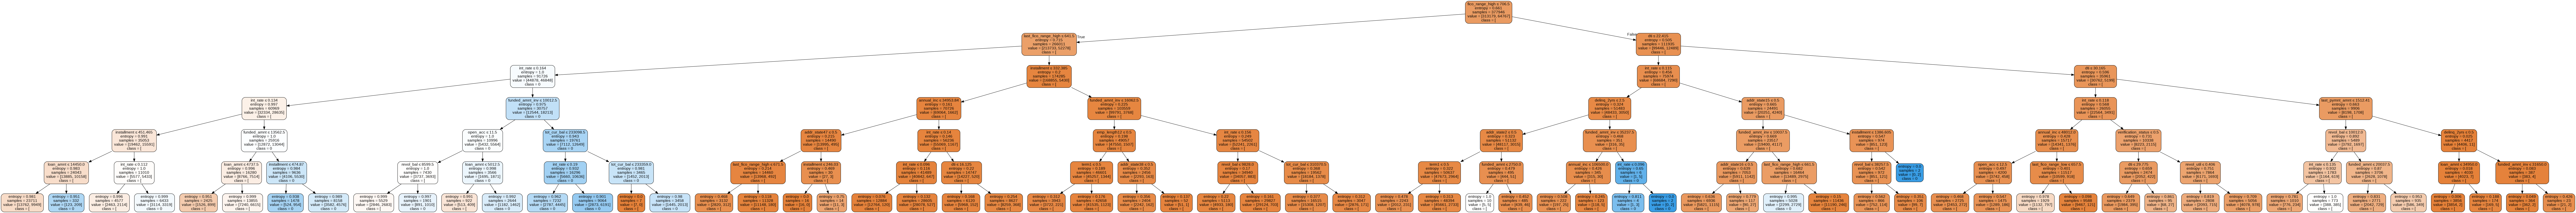

In [ ]:
# 의사결정트리 시각화를 위한 작업
# 트리 시각화를 위한 export_graphviz 모듈 임포트 (이를 위해 graphviz 별도 설치 필요)
from sklearn.tree import export_graphviz
import pydotplus  # graphviz의 dot language 와의 인터페이스를 제공하는 패키지 임포트
from IPython.display import Image  # IPython의 display와 관련된 Public API

x_list = list(df1_x_test.columns)
y_list = list(df1_y_test.drop_duplicates(inplace=False))

# export_graphviz() : 의사결정트리에 대한 graphviz dot data를 생성하는 함수
dot_data = export_graphviz(DT_best_model_df1, out_file=None, feature_names=x_list,
                          class_names=str(y_list), filled=True, rounded=True, special_characters=True)
# matplotlib.rc('font', family='AppleGothic')
graph = pydotplus.graph_from_dot_data(dot_data)  # graphviz의 dot data로부터 트리 그래프 생성

# 트리 그래프를 위한 png 이미지 생성 및 출력
Image(graph.create_png())

### 랜덤포레스트

In [ ]:
# valid set을 이용하여 max_dept, max_feature 결정 
RF_N = np.arange(5, 21, 1) 
RF_depth = np.arange(3, 10, 1) 
RF_best_df1, RF_best_per_df1, RF_valid_df1 = RF_find_N_depth(df1_x_train, df1_y_train, df1_x_valid, df1_y_valid, RF_N, RF_depth)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
RF_valid_df1

performance,n_estimators,depth,accuracy,recall,precision,expect_price
0,3,5,0.828723,0.000973,0.677419,-638.874629
1,4,5,0.859545,0.219742,0.848051,-272.951669
2,5,5,0.883873,0.447357,0.781581,97.358720
3,6,5,0.871356,0.302145,0.851122,-134.849221
4,7,5,0.890247,0.461253,0.819319,126.542114
...,...,...,...,...,...,...
107,5,20,0.874555,0.308954,0.882859,-120.447604
108,6,20,0.906733,0.557738,0.845398,291.817818
109,7,20,0.918592,0.665663,0.825493,467.837224
110,8,20,0.924918,0.734124,0.809945,577.883432


In [ ]:
RF_best_per_df1

,25
performance,
n_estimators,7.000000
depth,8.000000
accuracy,0.920259
recall,0.803187
precision,0.749449
expect_price,674.045406


In [ ]:
RF_best_df1

,25
performance,
n_estimators,7.0
depth,8.0


In [ ]:
# test set을 이용하여 예측 
RF_best_N_df1, RF_best_dep_df1, RF_best_model_df1, RF_cfmat_df1, RF_test_df1 = RF_best_N_depth(RF_best_df1, df1_x_train, df1_y_train, df1_x_test, df1_y_test)

In [ ]:
 RF_cfmat_df1

array([[100352,   4042],
       [  5483,  16106]])

In [ ]:
 RF_test_df1 

performance,accuracy,recall,precision,expect_price
1,0.924395,0.746028,0.799385,595.219639


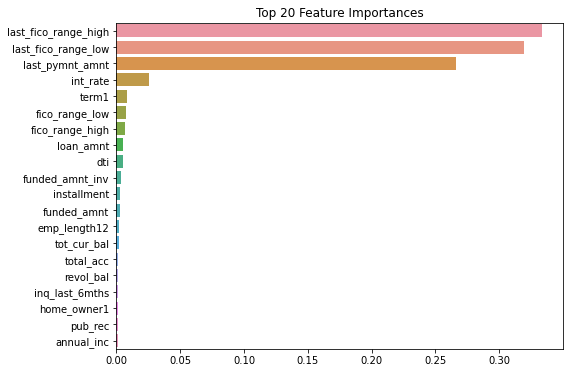

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

RF_importances_values = RF_best_model_df1.feature_importances_
RF_importances = pd.Series(RF_importances_values, index = x_train.columns)
RF_top20 = RF_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=RF_top20, y=RF_top20.index)
plt.show()

## 2.2 대출목적: 신용카드

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/7조 조별과제/통계데이터사이언스_프로젝트_0119/make csv/purpose_0126/purpose2_credit_card.csv') 
df2.shape

(253650, 88)

In [ ]:
# train: test = 8:2
df2_x = df1.drop(['depvar'],axis=1) 
df2_y = df1['depvar']

df2_x_Train, df2_x_test, df2_y_Train, df2_y_test = train_test_split(df2_x, df2_y, test_size=0.2, random_state=None, stratify=df2_y)
print(df2_x_Train.shape[0]); print(df2_x_test.shape[0])

503929
125983


In [ ]:
# train: Validation set = 6:2
df2_x_train, df2_x_valid, df2_y_train, df2_y_valid = train_test_split(df2_x_Train ,df2_y_Train, test_size=(2/8), random_state=None, stratify=df2_y_Train)
print(df2_x_train.shape[0]); print(df2_x_valid.shape[0])

377946
125983


### 로지스틱

In [ ]:
Logit_model_df2 = LogisticRegression(fit_intercept=False)
Logit_result_df2 = Logit_model_df2.fit(df2_x_train, df2_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Validation에 적합하여 threshold 구하기
Logit_y_valid_p_df2 = Logit_result_df2.predict_proba(df2_x_valid)[:,1] # 예측 된 y_valid 의 확률

Logit_threshold = np.arange(0, 1, 0.01) 
Logit_best_df2, Logit_best_perm_df2, Logit_valid_df2 = Logit_find_threshold(df2_y_valid, Logit_y_valid_p_df2, df2_x_valid, Logit_threshold)
Logit_valid_df2

performance,accuracy,recall,precision,expect_price
threshold,,,,
0.00,0.171364,1.000000,0.171364,-41.431780
0.01,0.615662,0.998749,0.308227,554.700385
0.02,0.649873,0.998147,0.328396,599.852392
0.03,0.677091,0.997452,0.346429,635.455030
0.04,0.701023,0.995646,0.363909,664.986163
...,...,...,...,...
0.95,0.845511,0.114595,0.876683,-447.145670
0.96,0.845408,0.113576,0.878538,-448.795788
0.97,0.845424,0.112511,0.885527,-450.354349


In [ ]:
print(Logit_best_perm_df2)

                    0.16
performance             
accuracy        0.858973
recall          0.954468
precision       0.551110
expect_price  816.505464


In [ ]:
# Test에 적합한 결과 
Logit_y_test_p_df2 = Logit_result_df2.predict_proba(df2_x_test)[:,1]
Logit_best_threshold_df2, Logit_cfmat_df2, Logit_test_df2 = Logit_best_threshold(Logit_valid_df2, df2_y_test, Logit_y_test_p_df2, df2_x_test)

In [ ]:
Logit_cfmat_df2

array([[87711, 16683],
       [  992, 20597]])

In [ ]:
 Logit_test_df2

performance,accuracy,recall,precision,expect_price
threshold,,,,
0.16,0.859703,0.954051,0.552495,815.297613


In [ ]:
# 회귀 계수 값 
Logit_coef_df2_1 = pd.Series(Logit_result_df2.coef_[0], index = x_train.columns)
Logit_coef_df2 = Logit_coef_df2_1.sort_values(ascending=False)
round(Logit_coef_df2,5)

fico_range_high         0.00813
fico_range_low          0.00806
total_acc               0.00103
dti                     0.00081
open_acc                0.00035
                         ...   
term1                  -0.00002
installment            -0.00027
last_pymnt_amnt        -0.00152
last_fico_range_high   -0.00933
last_fico_range_low    -0.01032
Length: 87, dtype: float64

In [ ]:
round(np.exp(Logit_coef_df2),5)

fico_range_high         1.00816
fico_range_low          1.00810
total_acc               1.00103
dti                     1.00081
open_acc                1.00035
                         ...   
term1                   0.99998
installment             0.99973
last_pymnt_amnt         0.99849
last_fico_range_high    0.99071
last_fico_range_low     0.98973
Length: 87, dtype: float64

### 의사결정나무

In [ ]:
DT_model_df2 = DecisionTreeClassifier(criterion="entropy")
DT_result_df2 = DT_model_df2.fit(df2_x_train, df2_y_train)

In [ ]:
DT_result_df2.score

<bound method ClassifierMixin.score of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')>

In [ ]:
# valid set을 이용하여 max_depth와 max_feature 결정 
DT_depth = np.arange(3, 10, 1) 
DT_feature = np.arange(1, 10, 1) 
DT_best_df2, DT_best_per_df2, DT_valid_df2 = DT_find_depth_feature(df2_x_train, df2_y_train, df2_x_valid, df2_y_valid, DT_depth,  DT_feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
DT_valid_df2

performance,depth,max_feature,accuracy,recall,precision,expect_price
0,3,1,0.828636,0.000000,NaN,-639.803584
1,3,2,0.828636,0.000000,NaN,-639.803584
2,3,3,0.828691,0.000324,1.000000,-639.247954
3,3,4,0.828747,0.000648,1.000000,-638.692323
4,3,5,0.828636,0.000000,NaN,-639.803584
...,...,...,...,...,...,...
58,9,5,0.841018,0.279309,0.574286,-208.921915
59,9,6,0.845074,0.259113,0.613579,-233.412677
60,9,7,0.886270,0.824031,0.628200,659.807265
61,9,8,0.911218,0.821020,0.707698,688.919855


In [ ]:
DT_best_per_df2

,61
performance,
depth,9.000000
max_feature,8.000000
accuracy,0.911218
recall,0.821020
precision,0.707698
expect_price,688.919855


In [ ]:
DT_best_df2

,61
performance,
depth,9.0
max_feature,8.0


In [ ]:
# test set을 이용하여 예측 
DT_best_dep_df2, DT_best_feat_df2, DT_best_model_df2, DT_cfmat_df2, DT_test_df2 = DT_best_depth(DT_best_df2, df2_x_train, df2_y_train, df2_x_test, df2_y_test)

In [ ]:
print(DT_best_dep_df2, DT_best_feat_df2)

9 8


In [ ]:
DT_cfmat_df2

array([[96635,  7759],
       [ 9745, 11844]])

In [ ]:
DT_test_df2

performance,accuracy,recall,precision,expect_price
1,0.861061,0.548613,0.604193,215.699086


In [ ]:
# 의사결정트리 시각화를 위한 작업
# 트리 시각화를 위한 export_graphviz 모듈 임포트 (이를 위해 graphviz 별도 설치 필요)
from sklearn.tree import export_graphviz
import pydotplus  # graphviz의 dot language 와의 인터페이스를 제공하는 패키지 임포트
from IPython.display import Image  # IPython의 display와 관련된 Public API

x_list = list(df2_x_test.columns)
y_list = list(df2_y_test.drop_duplicates(inplace=False))

# export_graphviz() : 의사결정트리에 대한 graphviz dot data를 생성하는 함수
dot_data = export_graphviz(DT_best_model_df2, out_file=None, feature_names=x_list,
                          class_names=str(y_list), filled=True, rounded=True, special_characters=True)
# matplotlib.rc('font', family='AppleGothic')
graph = pydotplus.graph_from_dot_data(dot_data)  # graphviz의 dot data로부터 트리 그래프 생성

# 트리 그래프를 위한 png 이미지 생성 및 출력
Image(graph.create_png())

### 랜덤포레스트

In [ ]:
# valid set을 이용하여 max_dept, max_feature 결정 
RF_N = np.arange(5, 21, 1) 
RF_depth = np.arange(3, 10, 1) 
RF_best_df2, RF_best_per_df2, RF_valid_df2 = RF_find_N_depth(df2_x_train, df2_y_train, df2_x_valid, df2_y_valid, RF_N, RF_depth)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
RF_valid_df2

performance,n_estimators,depth,accuracy,recall,precision,expect_price
0,3,5,0.885183,0.669091,0.663650,428.567268
1,4,5,0.852036,0.199083,0.760977,-313.068895
2,5,5,0.848075,0.129464,0.889844,-421.644676
3,6,5,0.886262,0.427023,0.824745,71.033234
4,7,5,0.897296,0.532030,0.801983,241.608896
...,...,...,...,...,...,...
107,5,20,0.836264,0.048451,0.924845,-557.684590
108,6,20,0.902177,0.529066,0.841152,243.782804
109,7,20,0.905400,0.561953,0.831358,296.891891
110,8,20,0.920465,0.711196,0.802236,538.495998


In [ ]:
RF_best_per_df2

,89
performance,
n_estimators,8.000000
depth,17.000000
accuracy,0.924506
recall,0.784288
precision,0.777196
expect_price,652.330548


In [ ]:
RF_best_df2

,89
performance,
n_estimators,8.0
depth,17.0


In [ ]:
# test set을 이용하여 예측 
RF_best_N_df2, RF_best_dep_df2, RF_best_model_df2, RF_cfmat_df2, RF_test_df2 = RF_best_N_depth(RF_best_df2, df2_x_train, df2_y_train, df2_x_test, df2_y_test)

In [ ]:
RF_cfmat_df2

array([[99866,  4528],
       [ 4365, 17224]])

In [ ]:
RF_test_df2

performance,accuracy,recall,precision,expect_price
1,0.929411,0.797814,0.791835,677.200636


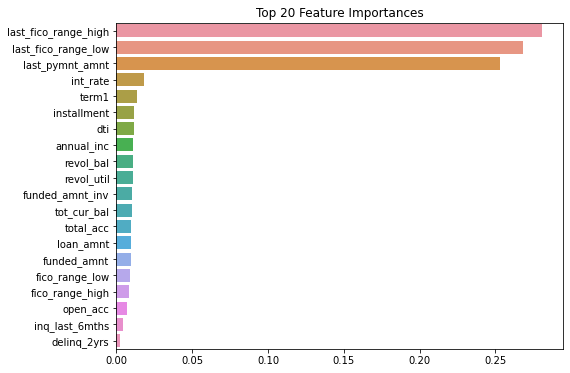

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

RF_importances_values = RF_best_model_df2.feature_importances_
RF_importances = pd.Series(RF_importances_values, index = x_train.columns)
RF_top20 = RF_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=RF_top20, y=RF_top20.index)
plt.show()